In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df = pd.read_csv('/content/drive/MyDrive/datathons/df_final_3.csv')

In [4]:
df_mirante = df[df['estacao']=='A711'][df['ano']<2020]
df_mirante

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,estacao,cidade,datetime,distribuidora,carga,temp_mean,ano,mes,dia,hora,...,hora_18,hora_19,hora_20,hora_21,hora_22,hora_23,cluster_0,cluster_1,cluster_2,cluster_3
5,A711,São Carlos,2018-01-01 00:00:00,CPFL PAULISTA,2569.709961,19.200000,2018,1,1,0,...,0,0,0,0,0,0,1,0,0,0
45,A711,São Carlos,2018-01-01 01:00:00,CPFL PAULISTA,2516.899902,19.033333,2018,1,1,1,...,0,0,0,0,0,0,1,0,0,0
85,A711,São Carlos,2018-01-01 02:00:00,CPFL PAULISTA,2423.010010,19.200000,2018,1,1,2,...,0,0,0,0,0,0,1,0,0,0
125,A711,São Carlos,2018-01-01 03:00:00,CPFL PAULISTA,2322.850098,19.233333,2018,1,1,3,...,0,0,0,0,0,0,1,0,0,0
165,A711,São Carlos,2018-01-01 04:00:00,CPFL PAULISTA,2250.669922,19.133333,2018,1,1,4,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
719582,A711,São Carlos,2019-12-31 22:00:00,CPFL PAULISTA,3367.604980,22.033333,2019,12,31,22,...,0,0,0,0,1,0,1,0,0,0
719583,A711,São Carlos,2019-12-31 22:00:00,CPFL PAULISTA,3367.604980,22.033333,2019,12,31,22,...,0,0,0,0,1,0,1,0,0,0
719707,A711,São Carlos,2019-12-31 23:00:00,CPFL PAULISTA,3201.879883,21.500000,2019,12,31,23,...,0,0,0,0,0,1,1,0,0,0
719708,A711,São Carlos,2019-12-31 23:00:00,CPFL PAULISTA,3201.879883,21.500000,2019,12,31,23,...,0,0,0,0,0,1,1,0,0,0


In [5]:
df_mirante = df_mirante[['cluster', 'temp_mean', 'carga']]

In [6]:
# prepare data for lstm
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

In [7]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 
# load dataset
dataset = df_mirante
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,2] = encoder.fit_transform(values[:,2])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var1(t)   var2(t)   var3(t)
1        0.0   0.485459   0.020465      0.0  0.479866  0.014186
2        0.0   0.479866   0.014186      0.0  0.485459  0.006802
3        0.0   0.485459   0.006802      0.0  0.486577  0.002733
4        0.0   0.486577   0.002733      0.0  0.483221  0.001221
5        0.0   0.483221   0.001221      0.0  0.473154  0.000640


In [8]:
reframed

,var1(t-1),var2(t-1),var3(t-1),var1(t),var2(t),var3(t)
1,0.0,0.485459,0.020465,0.0,0.479866,0.014186
2,0.0,0.479866,0.014186,0.0,0.485459,0.006802
3,0.0,0.485459,0.006802,0.0,0.486577,0.002733
4,0.0,0.486577,0.002733,0.0,0.483221,0.001221
5,0.0,0.483221,0.001221,0.0,0.473154,0.000640
...,...,...,...,...,...,...
17522,0.0,0.580537,0.273140,0.0,0.580537,0.273140
17523,0.0,0.580537,0.273140,0.0,0.580537,0.273140
17524,0.0,0.580537,0.273140,0.0,0.562640,0.203081
17525,0.0,0.562640,0.203081,0.0,0.562640,0.203081


In [9]:
train = values[:-90, :]
test = values[-90:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(17437, 1, 2) (17437,) (90, 1, 2) (90,)


In [10]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(None, train_X.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=350, batch_size=32, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Epoch 1/350
545/545 - 5s - loss: 8587.8594 - val_loss: 6093.6919 - 5s/epoch - 8ms/step
Epoch 2/350
545/545 - 1s - loss: 8561.3242 - val_loss: 6070.8271 - 1s/epoch - 2ms/step
Epoch 3/350
545/545 - 1s - loss: 8539.2451 - val_loss: 6049.0244 - 1s/epoch - 2ms/step
Epoch 4/350
545/545 - 1s - loss: 8517.7930 - val_loss: 6027.5610 - 1s/epoch - 2ms/step
Epoch 5/350
545/545 - 1s - loss: 8496.7070 - val_loss: 6006.2695 - 1s/epoch - 2ms/step
Epoch 6/350
545/545 - 1s - loss: 8475.6797 - val_loss: 5985.0737 - 1s/epoch - 2ms/step
Epoch 7/350
545/545 - 1s - loss: 8454.9863 - val_loss: 5963.9429 - 1s/epoch - 2ms/step
Epoch 8/350
545/545 - 1s - loss: 8434.0303 - val_loss: 5942.8223 - 1s/epoch - 2ms/step
Epoch 9/350
545/545 - 1s - loss: 8413.3145 - val_loss: 5921.7363 - 1s/epoch - 2ms/step
Epoch 10/350
545/545 - 1s - loss: 8393.1104 - val_loss: 5900.7051 - 1s/epoch - 2ms/step
Epoch 11/350
545/545 - 1s - loss: 8372.3057 - val_loss: 5879.6558 - 1s/epoch - 2ms/step
Epoch 12/350
545/545 - 1s - loss: 8352.10

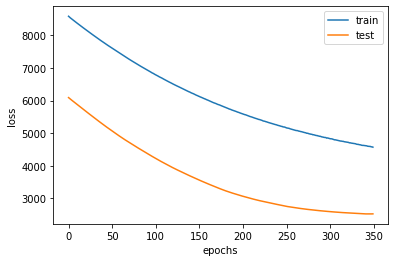

In [11]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train', 'test'])
plt.show()

In [12]:
Y_hat = model.predict(test_X)
Y_test = test_y.reshape(-1, 1)